In [12]:
import networkx as nx
import torch
from tqdm import trange, tqdm

from dql import DQGN, Agent
from graph import milp_solve_mds, prepare_graph, mds_is_solved

In [23]:
n, p = 10, .15
tt_g = 10000
graphs = []

print(f'sampling {tt_g} x G{n, p}')
for i in trange(tt_g):
    g = prepare_graph(i, n, p, milp_solve_mds, g_nx=True)
    graphs.append(g)

sampling 10000 x G(10, 0.15)


100%|██████████| 10000/10000 [00:10<00:00, 937.28it/s]


In [24]:
ckp_path = './experiments/2024-11-06-1120/version_0/checkpoints/epoch=99-step=99.ckpt'
device = torch.device('cpu')
checkpoint = torch.load(ckp_path, map_location=device)
hyper_parameters = checkpoint['hyper_parameters']

state_dict = {k.replace('net.', ''): v for k, v in checkpoint['state_dict'].items() if 'target' not in k}
state_dict.pop('loss_module.pos_weight', None)

c_in = graphs[0].x.shape[1]
gnn = DQGN(c_in=c_in, n=n)
gnn.load_state_dict(state_dict)
gnn.eval()
gnn

DQGN(
  (layers): ModuleList(
    (0): GCNConv(1, 64)
    (1): ReLU(inplace=True)
    (2): GCNConv(64, 64)
    (3): ReLU(inplace=True)
    (4): GCNConv(64, 64)
    (5): ReLU(inplace=True)
    (6): GCNConv(64, 64)
    (7): ReLU(inplace=True)
    (8): GCNConv(64, 64)
    (9): ReLU(inplace=True)
    (10): GCNConv(64, 64)
    (11): ReLU(inplace=True)
    (12): GCNConv(64, 64)
    (13): ReLU(inplace=True)
    (14): GCNConv(64, 64)
    (15): ReLU(inplace=True)
    (16): GCNConv(64, 64)
    (17): ReLU(inplace=True)
  )
  (node_transform): Linear(in_features=64, out_features=64, bias=False)
  (neig_transform): Linear(in_features=64, out_features=64, bias=False)
  (aggr_transform): Linear(in_features=128, out_features=1, bias=False)
  (relu): ReLU(inplace=True)
  (tanh): Tanh()
)

In [25]:
agent = Agent(n, p, None, None, None, graphs)

In [26]:
valid_ds = []
size_eq_mlip = []
apx_ratio = []

print(f'solving mds')
for g in tqdm(graphs):
    agent.state = g
    # Perform an episode of actions
    for step in range(n):
        rwd, done = agent.play_validation_step(gnn, 'cpu')
        if done:
            break
    g.s = {i for i, v in enumerate(agent.state.x) if v == 1}

    valid_ds.append(all(v in g.s or len(g.nx[v].keys() & g.s) > 0 for v in g.nx))
    len_sol = len([i for i in g.y if i])
    size_eq_mlip.append(len(g.s) <= len_sol)
    apx_ratio.append(len(g.s)/len_sol)

solving mds


100%|██████████| 10000/10000 [00:58<00:00, 170.52it/s]


In [27]:
print(f'{100*sum(valid_ds)/tt_g}% valid DS      {100*sum(size_eq_mlip)/tt_g}% equivalent to MILP        {sum(apx_ratio)/tt_g:.3f} apx ratio')

100.0% valid DS      85.23% equivalent to MILP        1.045 apx ratio


In [28]:
g_gen = (g for g in graphs if len(g.s) > len([i for i in g.y if i]))

{9, 2, 5, 6}


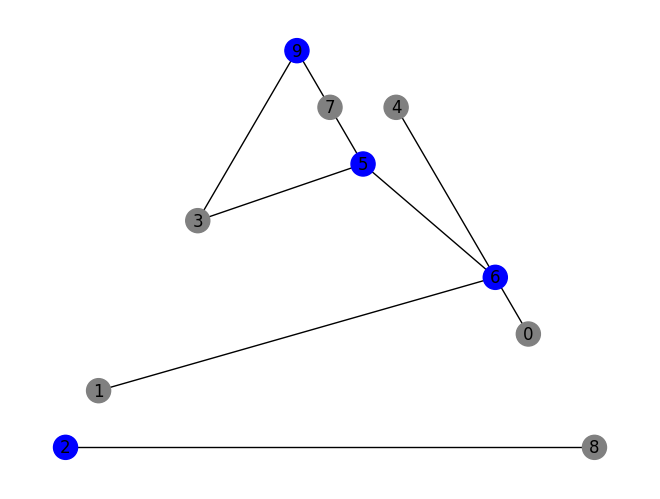

In [29]:
g = next(g_gen)
g_n = g.nx

try:
    layout = nx.planar_layout(g_n)
except:
    layout = nx.drawing.spring_layout(g_n)

node_colors = ['blue' if n in g.s else 'gray' for n in g.nx]
nx.draw(g_n, with_labels=True, node_color=node_colors, pos=layout)
print(g.s)

In [30]:
g.y

tensor([[0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.]])

In [31]:
edge_index, node_feats = g.edge_index, torch.FloatTensor([[0]] * n)
q_values = gnn(node_feats, edge_index).squeeze().tolist()
sorted(enumerate(q_values), key=lambda qv: qv[1], reverse=True)

[(6, -0.19931308925151825),
 (5, -0.199571892619133),
 (2, -0.19964326918125153),
 (8, -0.19964326918125153),
 (9, -0.19965860247612),
 (3, -0.1996879279613495),
 (7, -0.1996879279613495),
 (0, -0.19982856512069702),
 (1, -0.19982856512069702),
 (4, -0.19982856512069702)]

In [32]:
edge_index, node_feats = g.edge_index, torch.FloatTensor([[0], [0], [0], [1], [0], [0], [0], [0], [0], [0]])
q_values = gnn(node_feats, edge_index).squeeze().tolist()
sorted(enumerate(q_values), key=lambda qv: qv[1], reverse=True)

[(6, -0.19873489439487457),
 (5, -0.19899581372737885),
 (2, -0.19907712936401367),
 (8, -0.19907712936401367),
 (9, -0.1990964114665985),
 (7, -0.19912336766719818),
 (3, -0.19912339746952057),
 (0, -0.19926230609416962),
 (1, -0.19926230609416962),
 (4, -0.19926230609416962)]